## Preprocess Corpus

In [1]:
corpus = """
Batman is an American superhero. 
The secret identity of Batman is Bruce Wayne, an American billionaire from Gotham City. 
The Joker is a supervillain that embodies the ideas of anarchy and chaos. 
The Joker and Batman fight the battle for Gotham’s soul.
"""

# lowercase
all_text = corpus.lower()
# remove punctuation
all_text = all_text.replace('.', '')
all_text = all_text.replace(',', '')
all_text = all_text.replace('\n', '')

# add start and end token
all_text = f"<s> {all_text} </s>"

print(all_text)

<s> batman is an american superhero the secret identity of batman is bruce wayne an american billionaire from gotham city the joker is a supervillain that embodies the ideas of anarchy and chaos the joker and batman fight the battle for gotham’s soul </s>


In [2]:
def tokenize(text: str, remove_sw=False) -> list:
    s = text.split(" ")
    return s

all_tokens = tokenize(all_text)

In [3]:
print(f"Token types : {len(set(all_tokens))}")
print(f"Token count : {len(all_tokens)}")

Token types : 31
Token count : 44


## Unigram (N = 1)

In [4]:
from collections import Counter

vocabulary = Counter(all_tokens)

In [5]:
vocabulary

Counter({'the': 5,
         'batman': 3,
         'is': 3,
         'an': 2,
         'american': 2,
         'of': 2,
         'joker': 2,
         'and': 2,
         '<s>': 1,
         'superhero': 1,
         'secret': 1,
         'identity': 1,
         'bruce': 1,
         'wayne': 1,
         'billionaire': 1,
         'from': 1,
         'gotham': 1,
         'city': 1,
         'a': 1,
         'supervillain': 1,
         'that': 1,
         'embodies': 1,
         'ideas': 1,
         'anarchy': 1,
         'chaos': 1,
         'fight': 1,
         'battle': 1,
         'for': 1,
         'gotham’s': 1,
         'soul': 1,
         '</s>': 1})

vocabulary also serves as unigram counts.

In [6]:
vocabulary_size = len(vocabulary)
print(f"Vocabulary size: {vocabulary_size}")

unigram_counts = vocabulary

Vocabulary size: 31


Plot top 5 unigrams

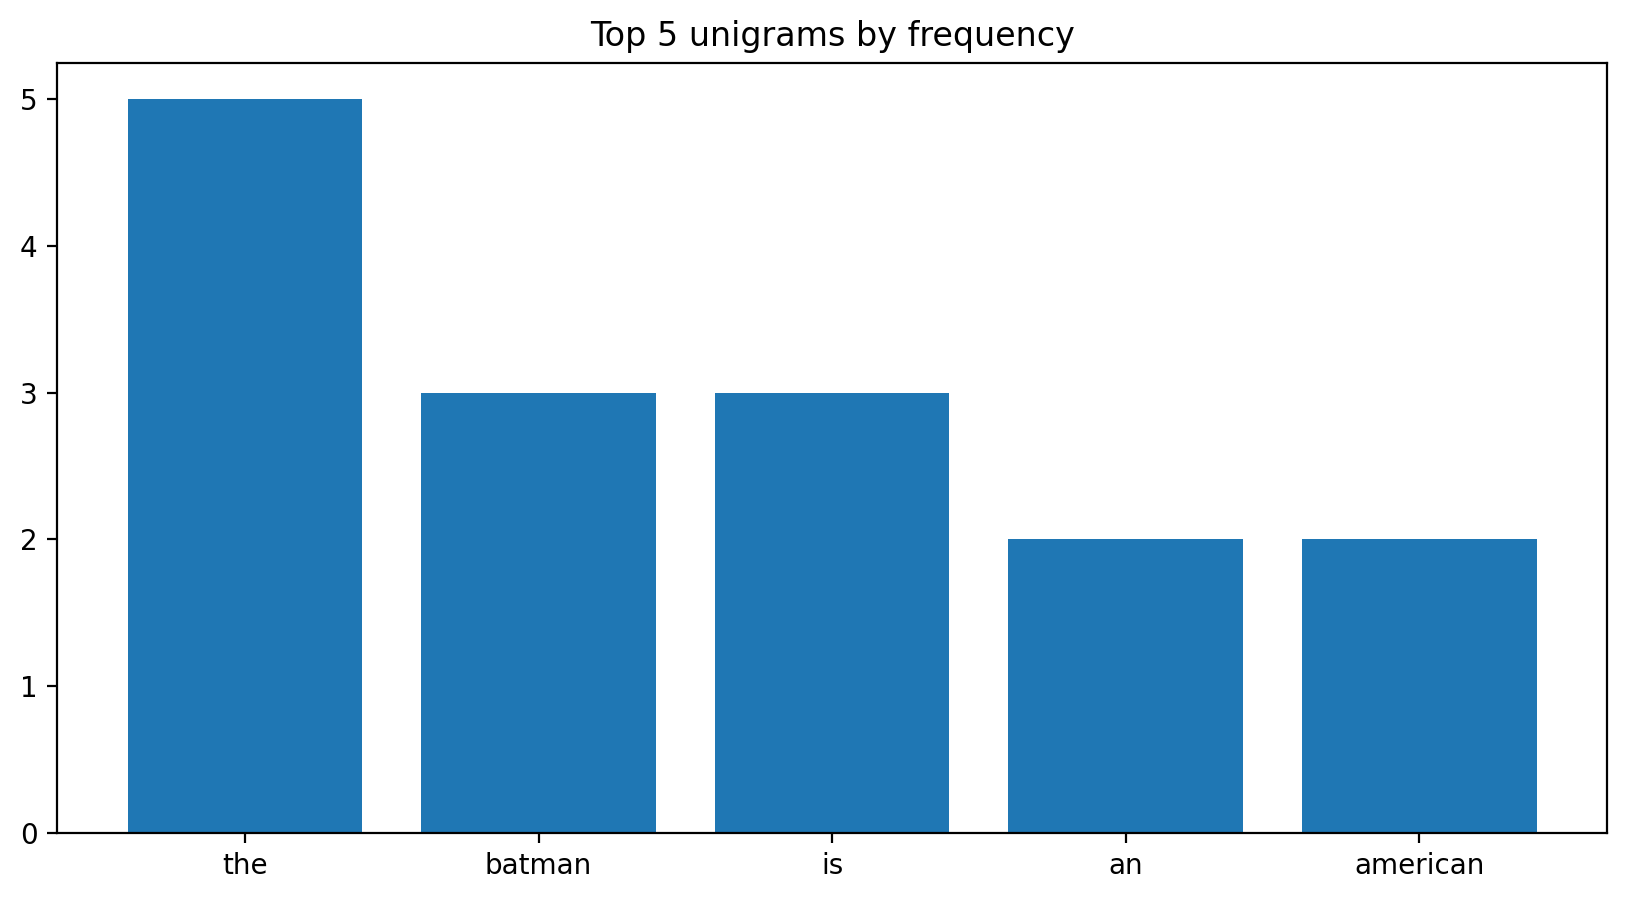

In [7]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt



top_5_unigrams = unigram_counts.most_common(5)
# plot top 50 words as a bar chart
plt.figure(figsize=(10, 5))
plt.bar([x[0] for x in top_5_unigrams], [x[1] for x in top_5_unigrams]) 
plt.title("Top 5 unigrams by frequency")
plt.show()

Get unigram probabilities

In [8]:
unigram_probabilities = {
    word: count / len(all_tokens) for word, count in unigram_counts.items()
}

Now that we have the probabilities, we can create word to idx mappings for generation

In [9]:
unigram_to_idx = {w: i for i, (w, _) in enumerate(unigram_counts.items())}
idx_to_unigram = {i: w for i, (w, _) in enumerate(unigram_counts.items())}

generate using multinomial sampling

In [10]:
import torch
from typing import List, Tuple, Dict, Any
torch.manual_seed(42)

PROBA_TYPE = Dict[str, float]

def generate(probabilities: PROBA_TYPE, idx_to_word: dict, num_words=10):
    p_values = [p for _, p in probabilities.items()]
    p_values = torch.tensor(p_values).softmax(dim=-1)
    
    idxs = torch.multinomial(p_values, num_words)
    
    generated = [idx_to_word[i.item()] for i in idxs]
    generated = " ".join(generated)
    
    return generated

In [11]:
# generate 10 sentences
generated_sentences = [generate(unigram_probabilities, idx_to_unigram) for _ in range(10)]
generated_sentences

['fight a billionaire from embodies <s> batman of anarchy wayne',
 'superhero embodies batman supervillain for soul from wayne gotham’s and',
 'city superhero <s> </s> for anarchy gotham’s the chaos and',
 'that secret fight city bruce billionaire from joker gotham’s of',
 'fight for from american bruce batman billionaire is joker chaos',
 'city secret batman superhero embodies and a american identity battle',
 'identity embodies a anarchy gotham superhero of the chaos for',
 'billionaire and battle identity for from </s> that gotham batman',
 'anarchy </s> from that billionaire superhero soul an of city',
 'the is <s> city of anarchy identity for soul an']

## Bigrams (N = 2)

In [12]:
# create bigrams from all_tokens
bigrams = [(all_tokens[i], all_tokens[i+1]) for i in range(len(all_tokens)-1)]
bigrams[:10]

[('<s>', 'batman'),
 ('batman', 'is'),
 ('is', 'an'),
 ('an', 'american'),
 ('american', 'superhero'),
 ('superhero', 'the'),
 ('the', 'secret'),
 ('secret', 'identity'),
 ('identity', 'of'),
 ('of', 'batman')]

In [13]:
bigram_counts = Counter(bigrams)

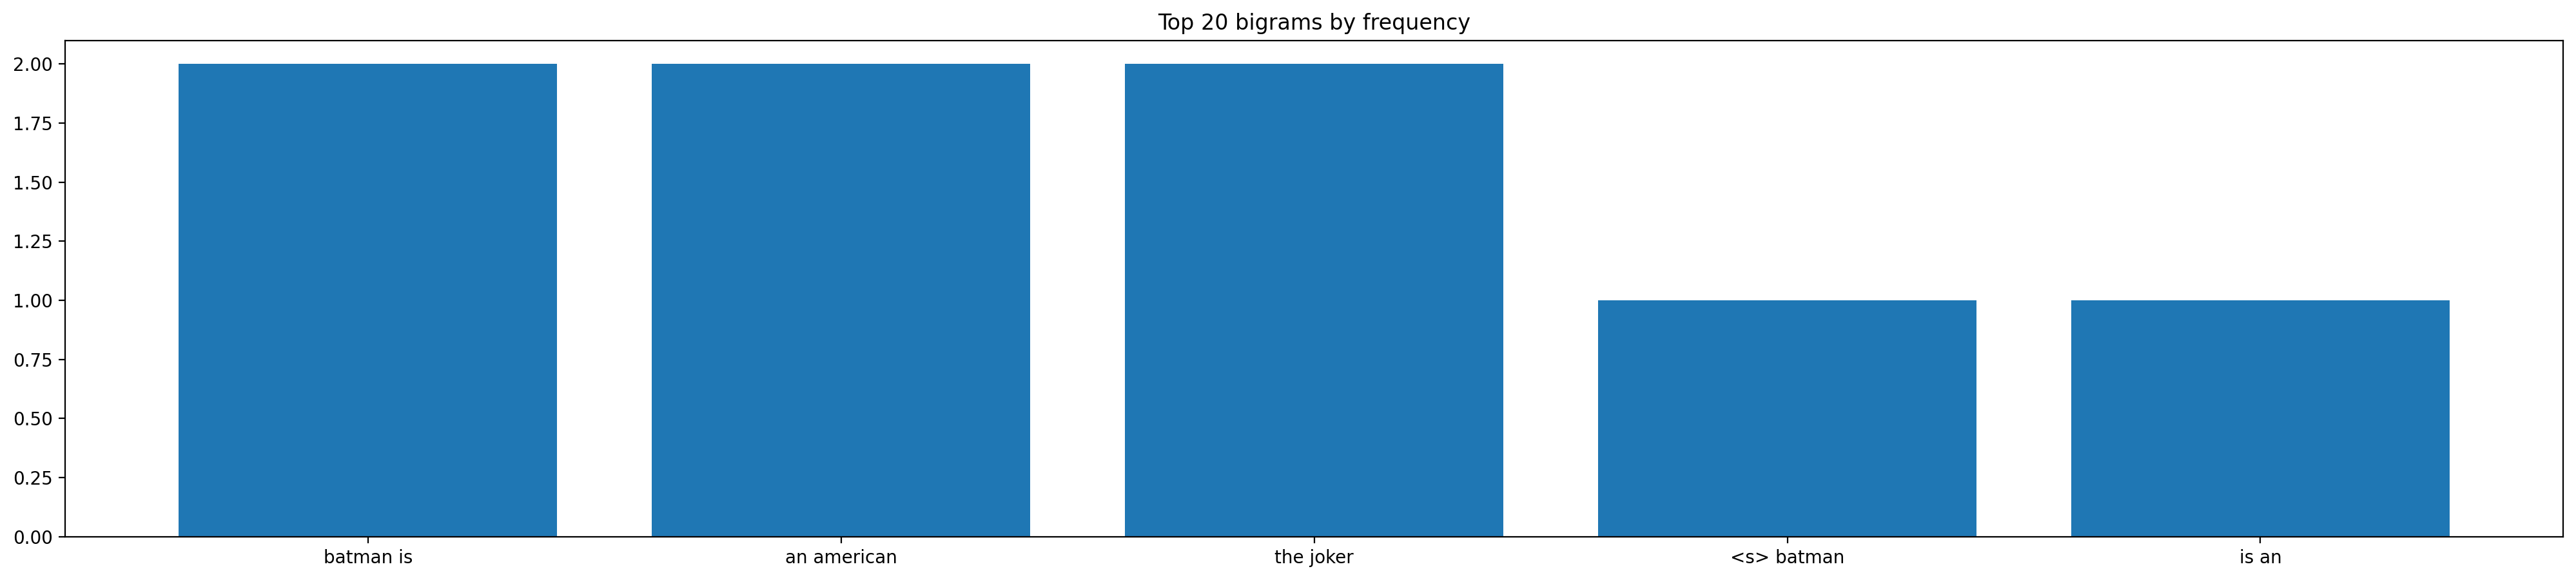

In [14]:
top_5_bigrams = bigram_counts.most_common(5)
# plot top 20 bigrams as a bar chart
plt.figure(figsize=(25, 5))
plt.bar([" ".join(x[0])  for x in top_5_bigrams], [x[1] for x in top_5_bigrams])
plt.title("Top 20 bigrams by frequency")
plt.show()

In [15]:
# bigram probabilities
bigram_probabilities = dict()
for bigram, count in bigram_counts.items():
    word1, word2 = bigram
    bigram_probabilities[bigram] = count / unigram_counts[word1]

In [16]:
bigram_to_idx = {i: " ".join(w) for i, (w, _) in enumerate(bigram_counts.items())}

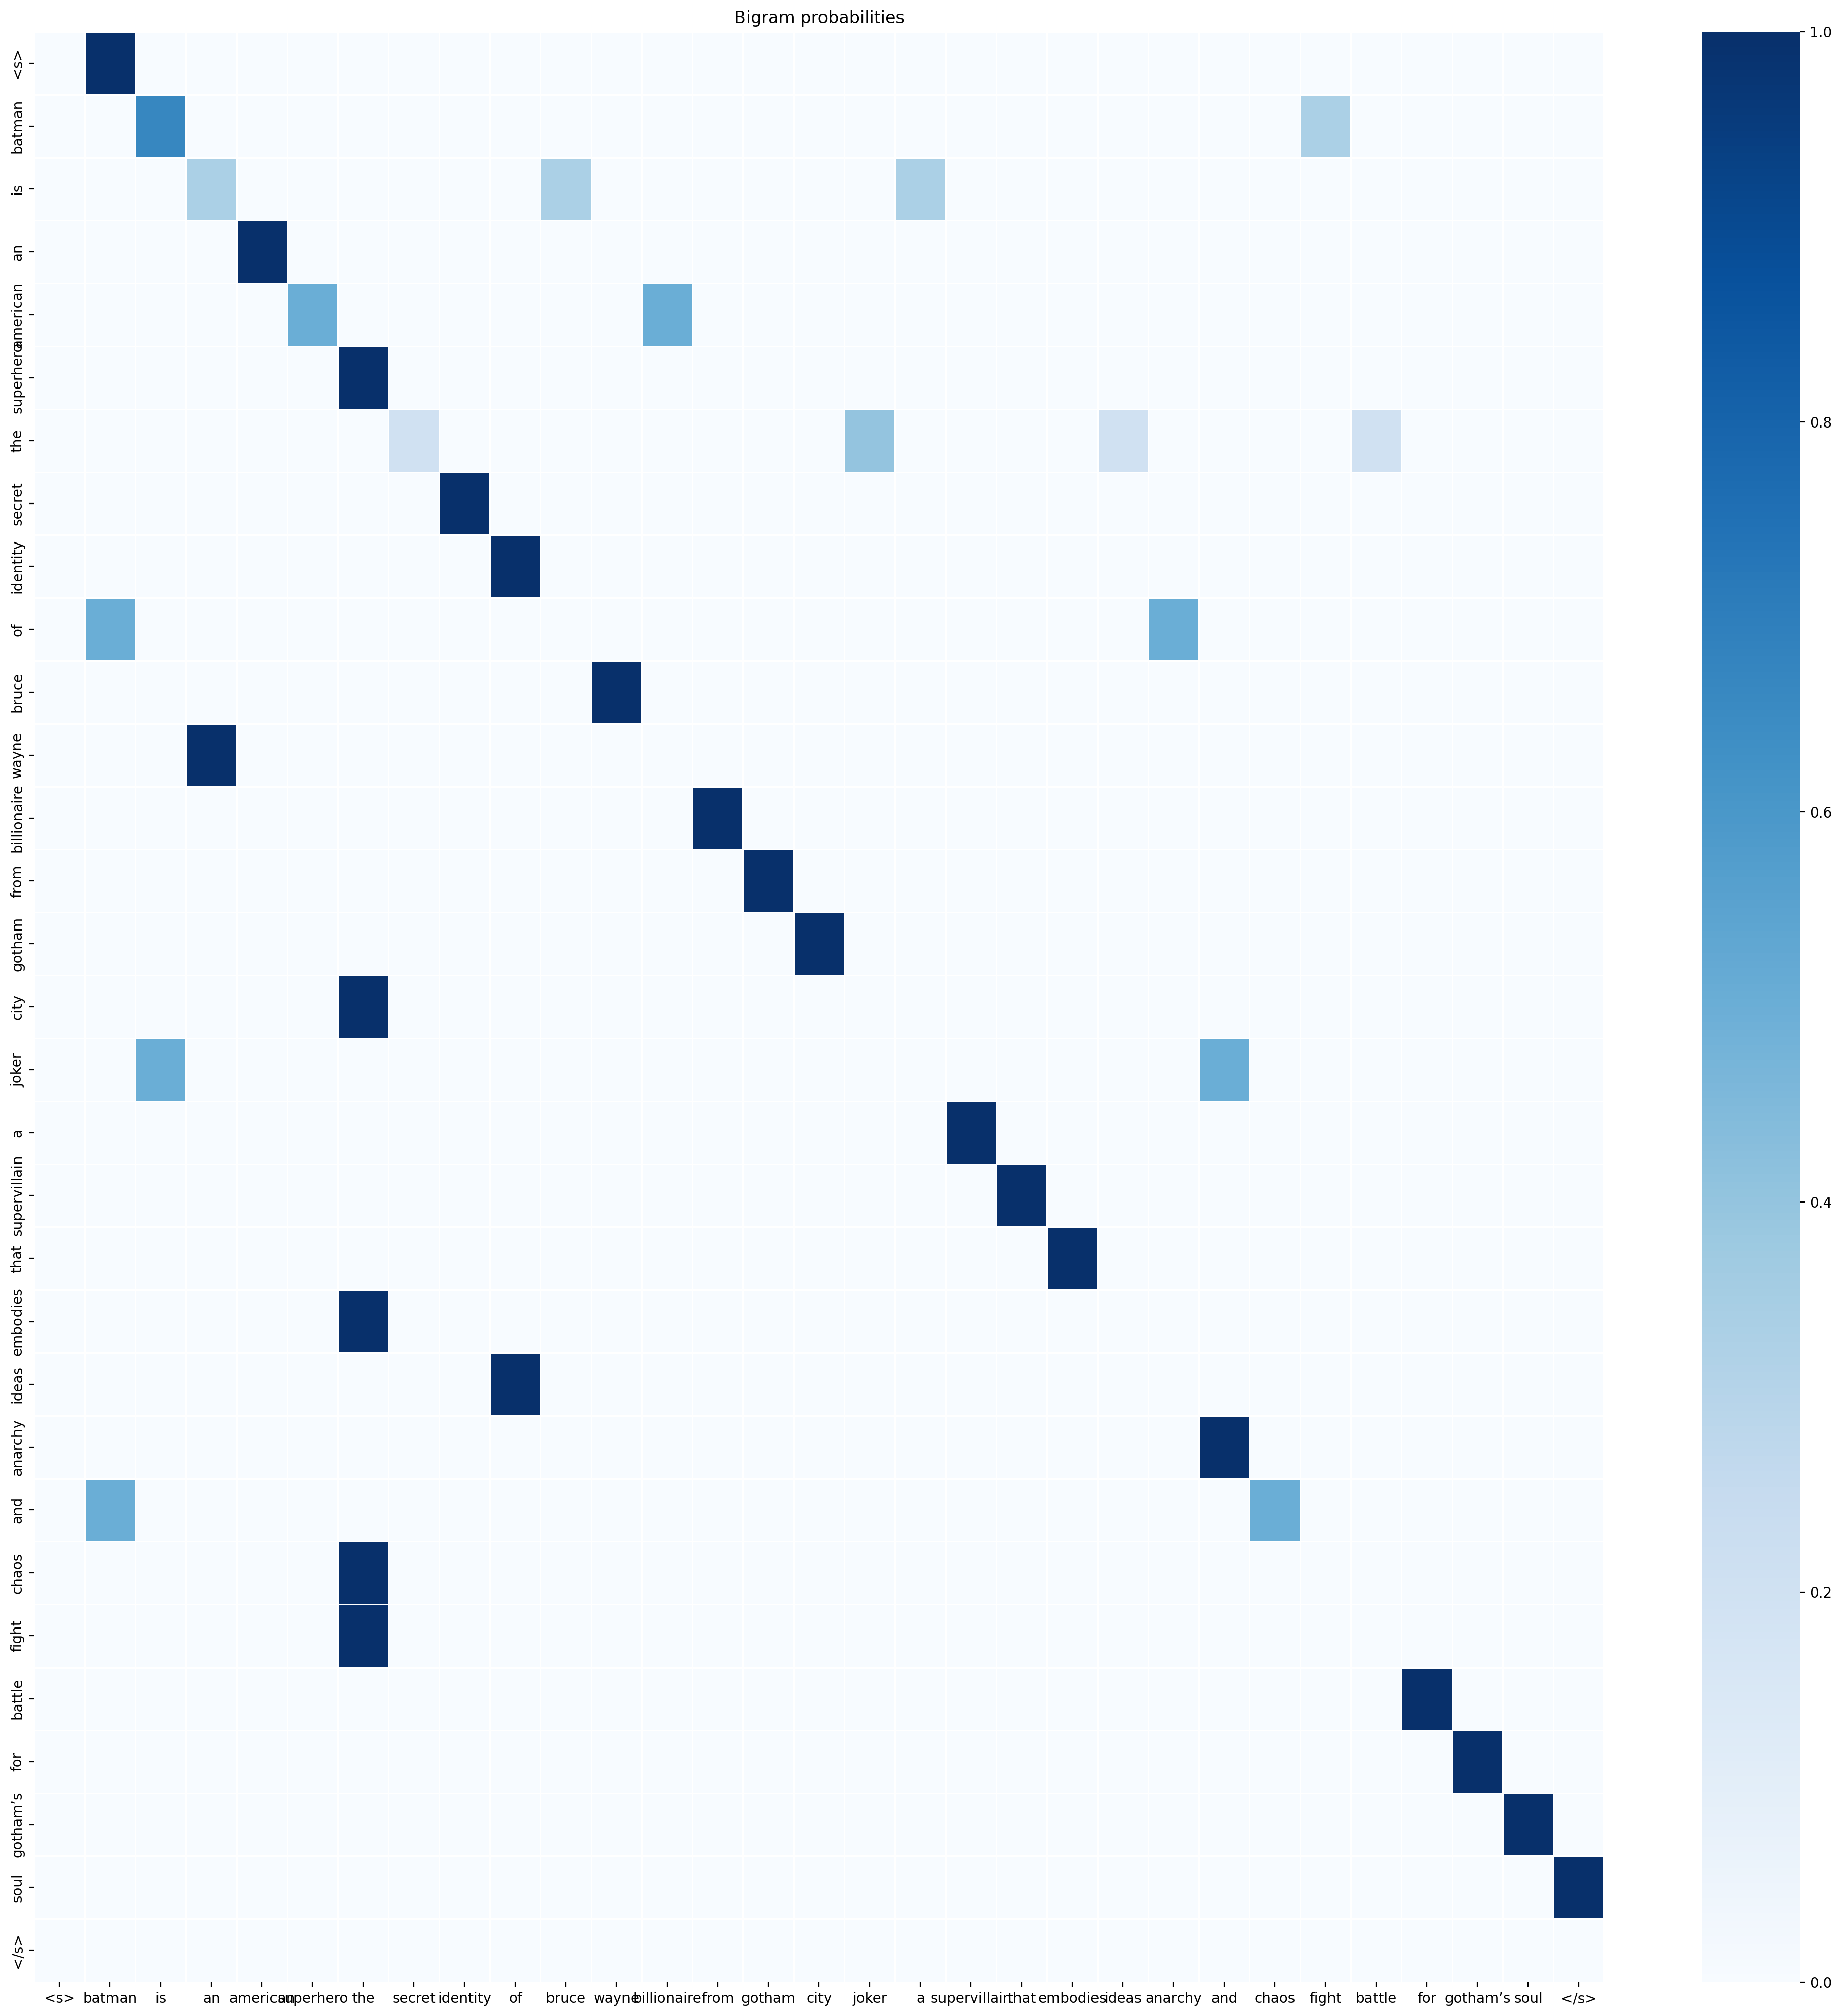

In [17]:
# plot bigram probabilities as a grid
import numpy as np
import seaborn as sns


bigram_matrix = np.zeros((vocabulary_size, vocabulary_size))
for bigram, p in bigram_probabilities.items():
    word1, word2 = bigram
    bigram_matrix[unigram_to_idx[word1], unigram_to_idx[word2]] = p
        
        
plt.figure(figsize=(25, 25))
ax = sns.heatmap(bigram_matrix, linewidth=0.5, cmap="Blues")
ax.set_xticklabels(idx_to_unigram.values())
ax.set_yticklabels(idx_to_unigram.values())
plt.title("Bigram probabilities")
plt.show()

In [18]:
for _ in range(10):
    print(generate(bigram_probabilities, bigram_to_idx))

and chaos fight the and batman wayne an of batman an american is an city the that embodies is a
secret identity bruce wayne from gotham of anarchy supervillain that identity of soul </s> the battle battle for american billionaire
city the billionaire from superhero the soul </s> supervillain that identity of battle for that embodies gotham’s soul the joker
city the <s> batman billionaire from supervillain that joker and from gotham and batman soul </s> bruce wayne embodies the
chaos the battle for american superhero from gotham soul </s> a supervillain anarchy and superhero the gotham’s soul city the
wayne an supervillain that soul </s> anarchy and secret identity batman fight gotham city is an and batman from gotham
embodies the an american the battle anarchy and joker and is a bruce wayne wayne an identity of from gotham
secret identity the battle is an superhero the gotham’s soul fight the for gotham’s anarchy and battle for and batman
bruce wayne battle for and chaos from gotham em

## Trigrams (N = 3)

In [19]:
# create trigrams from all_tokens
trigrams = [(all_tokens[i], all_tokens[i+1], all_tokens[i+2])
            for i in range(len(all_tokens)-2)]
trigrams[:10]

[('<s>', 'batman', 'is'),
 ('batman', 'is', 'an'),
 ('is', 'an', 'american'),
 ('an', 'american', 'superhero'),
 ('american', 'superhero', 'the'),
 ('superhero', 'the', 'secret'),
 ('the', 'secret', 'identity'),
 ('secret', 'identity', 'of'),
 ('identity', 'of', 'batman'),
 ('of', 'batman', 'is')]

In [20]:
trigram_counts = Counter(trigrams)
trigram_to_idx = {i: " ".join(w) for i, (w, _) in enumerate(trigram_counts.items())}

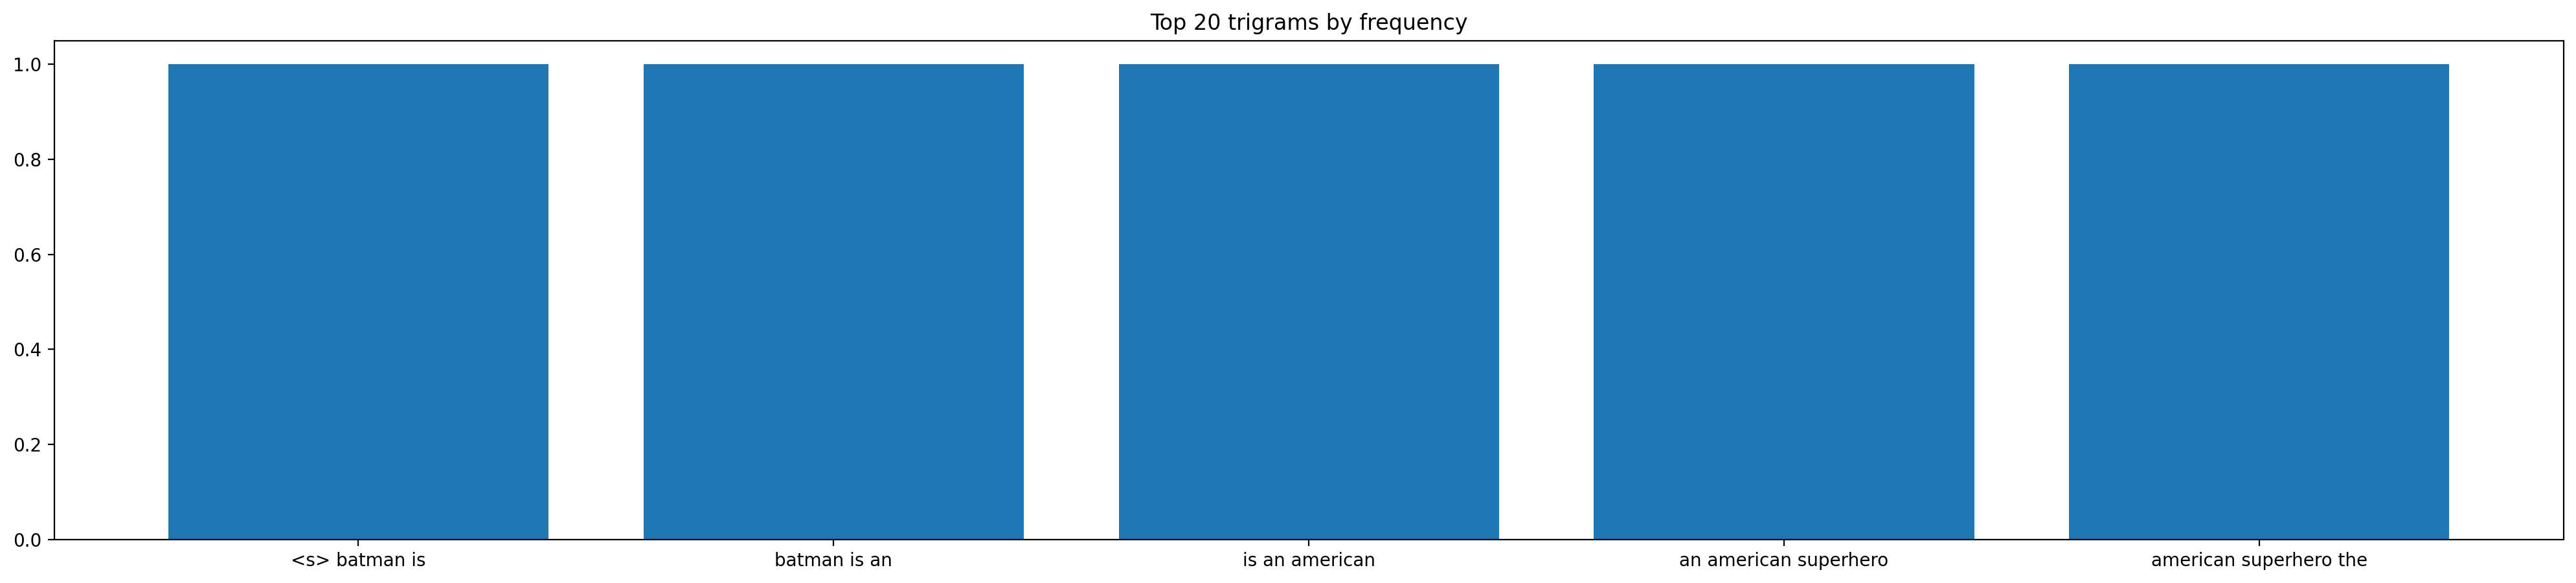

In [21]:
top_5_trigrams = trigram_counts.most_common(5)
# plot top 20 trigrams as a bar chart
plt.figure(figsize=(25, 5))
plt.bar([" ".join(x[0])  for x in top_5_trigrams], [x[1] for x in top_5_trigrams])
plt.title("Top 20 trigrams by frequency")
plt.show()

In [22]:
trigram_probabilities = dict()
for trigram, count in trigram_counts.items():
    word1, word2, word3 = trigram
    trigram_probabilities[trigram] = count / bigram_counts[(word1, word2)]

In [23]:
# generate 10 sentences
for _ in range(10):
    print(generate(trigram_probabilities, trigram_to_idx))

anarchy and chaos city the joker identity of batman of batman is batman is bruce gotham city the fight the battle wayne an american batman fight the that embodies the
wayne an american is a supervillain batman is bruce the ideas of is bruce wayne gotham’s soul </s> an american superhero the battle for the secret identity secret identity of
the battle for embodies the ideas american superhero the <s> batman is ideas of anarchy bruce wayne an is bruce wayne the secret identity battle for gotham’s is a supervillain
the battle for gotham’s soul </s> chaos the joker for gotham’s soul wayne an american the ideas of ideas of anarchy of anarchy and joker and batman superhero the secret
secret identity of and chaos the the secret identity billionaire from gotham of batman is identity of batman supervillain that embodies american superhero the gotham’s soul </s> is bruce wayne
a supervillain that and chaos the american billionaire from is an american <s> batman is an american billionaire gotham’

## Evaluation

In [24]:
from tqdm.auto import tqdm
from typing import List, Tuple, Dict, Any


PROBA_TYPE = Dict[str, float]

def perplexity(probabilities: PROBA_TYPE, tokens: list) -> float:
    # a very naive smoothing technique
    # just return 1 if an ngram didn't appear in the training data
    token_probabilities = [probabilities.get(t, 1.0) for t in tokens]
    token_probabilities = torch.tensor(token_probabilities)

    perplexity_score = torch.exp(
        -torch.log(token_probabilities).mean()
    ).item()

    return perplexity_score


# why? a progressbar looks nice!


def evaluate(ngram_probabilities: PROBA_TYPE, generated_sentences: list, N: int = 1):
    ppx_scores = []
    
    for _, ts in tqdm(enumerate(generated_sentences)):
        
        if N == 2:
            # create bigrams from ts
            ts = ts.split(" ")
            bigrams = [(ts[i], ts[i+1]) for i in range(len(ts)-1)]
            ppx = perplexity(ngram_probabilities, bigrams)
            ppx_scores.append(ppx)
        elif N == 3:
            # create trigrams from ts
            ts = ts.split(" ")
            trigrams = [(ts[i], ts[i+1], ts[i+2]) for i in range(len(ts)-2)]
            ppx = perplexity(ngram_probabilities, trigrams)
            ppx_scores.append(ppx)
        else:
            # create unigrams from ts
            ts = ts.split(" ")
            ppx = perplexity(ngram_probabilities, ts)
            ppx_scores.append(ppx)
        

    avg_ppx = sum(ppx_scores) / len(ppx_scores)
    return avg_ppx


avg_unigram_ppx = evaluate(unigram_probabilities, generated_sentences)
avg_unigram_ppx

0it [00:00, ?it/s]

35.11403846740723

In [25]:
avg_bigram_ppx = evaluate(bigram_probabilities, generated_sentences, N=2)
avg_bigram_ppx

0it [00:00, ?it/s]

1.0160119533538818

In [26]:
avg_trigram_ppx = evaluate(trigram_probabilities, generated_sentences, N=3)
avg_trigram_ppx

0it [00:00, ?it/s]

1.0

Text(0, 0.5, 'Average perplexity')

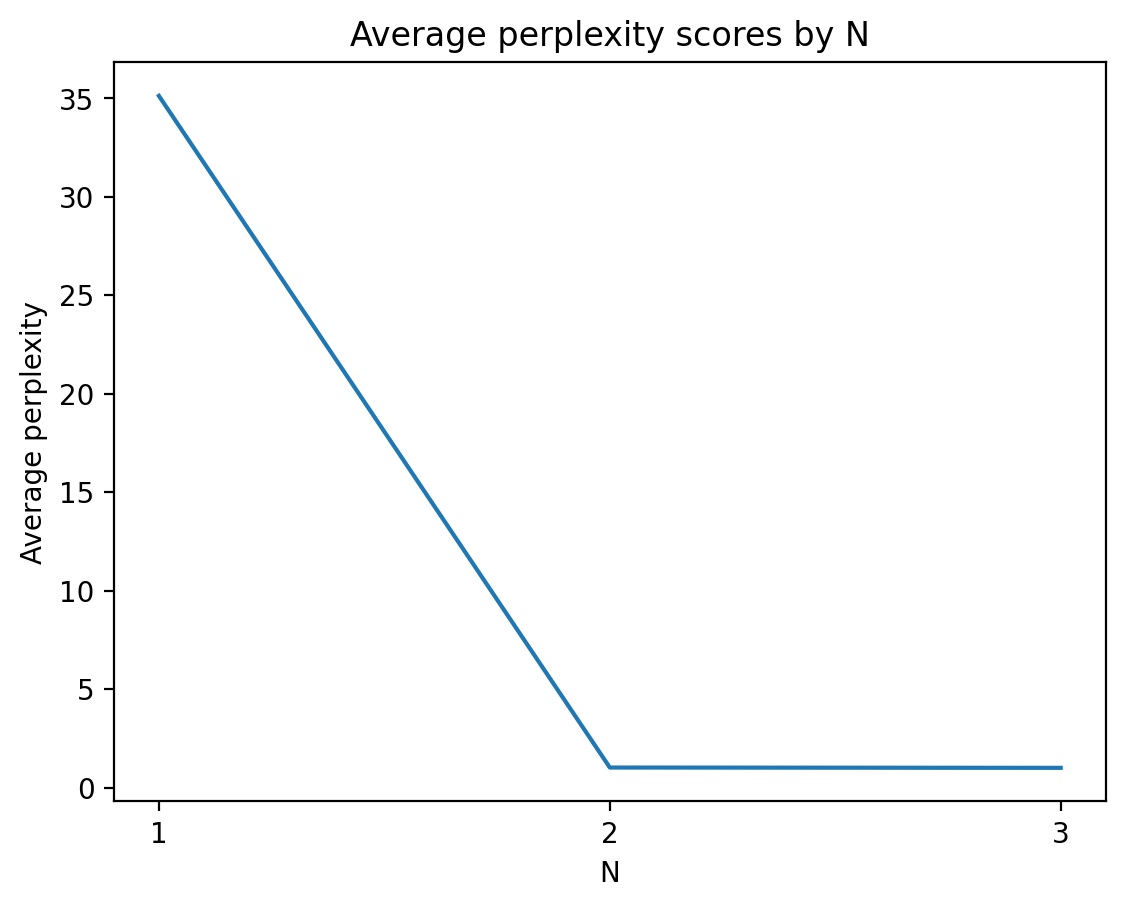

In [27]:
plt.plot(np.arange(3), [avg_unigram_ppx, avg_bigram_ppx, avg_trigram_ppx])
plt.title("Average perplexity scores by N")
plt.xlabel("N")
plt.xticks(np.arange(3), ["1", "2", "3"])
plt.ylabel("Average perplexity")